## Lecture 10 – Data 100, Spring 2022

by Lisa Yan

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

In [9]:
# big font helper
def adjust_fontsize(size=None):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    if size != None:
        SMALL_SIZE = MEDIUM_SIZE = BIGGER_SIZE = size

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Minimizing MSE is Minimizing Squared Residuals

Code used to generate the lecture plot.

This dataset is from Data 8 Textbook chapter 15.3 ([link](https://inferentialthinking.com/chapters/15/3/Method_of_Least_Squares.html)).

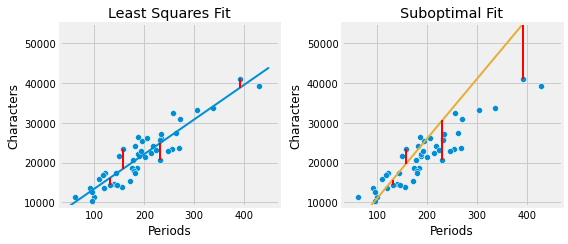

In [3]:
plt.style.use('fivethirtyeight')
%matplotlib inline
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

use_good = False

lw_df = pd.read_csv("data/little_women.csv")

linear_fits = [
    #    a,   b,     label,    color
    ( 4745,  87,  "Least Squares Fit", colors[0]),
    (-4000, 150,  "Suboptimal Fit", colors[2]),
    #(50000, -50, "Bad Fit", colors[3])
]

# create 2 subplots stacked into 2 columns (i.e. 1 x 2)
nplots = len(linear_fits)
fig, axs = plt.subplots(1, nplots, figsize=(4*nplots, 3.5))
for i in range(nplots):
    ax = axs[i]
    a, b, label, color = linear_fits[i]
    
    # plot data and line
    sns.scatterplot(data=lw_df, x="Periods", y="Characters", ax=ax)
    xlims = np.array([50, 450])
    ax.plot(xlims, a + b * xlims, lw=2, label=label, c=color)

    # plot residuals for some points
    sample = [[131, 14431], [231, 20558], [392, 40935], [157, 23524]]
    for x, y in sample:
        yhat = a + b*x
        ax.plot([x, x], [y, yhat], color='r', lw=2)
    ax.set_title(label)
    ax.set_ylim((9000, 55000))
fig.tight_layout()
#plt.savefig('residuals.png') # uncomment to save figure

# Dugongs Part 1

## Comparing Two Different Models, Both Fit with MSE

In [4]:
dugongs = pd.read_csv("data/dugongs.csv")
data_constant = dugongs["Age"]
data_linear = dugongs[["Length", "Age"]]

## Loss Surfaces

Computes constant loss surface

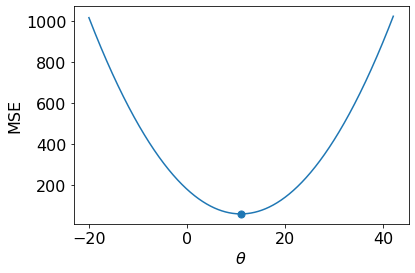

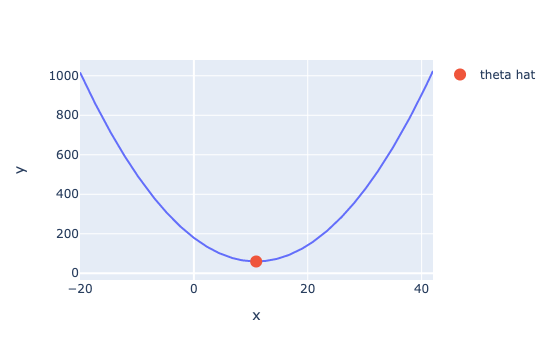

In [41]:
plt.style.use('default') # revert style to default mpl
adjust_fontsize(size=16)
%matplotlib inline

def mse_constant(theta, data):
    return np.mean(np.array([(y_obs - theta) ** 2 for y_obs in data]), axis=0)

thetas = np.linspace(-20, 42, 1000)
l2_loss_thetas = mse_constant(thetas, data_constant)

plt.plot(thetas, l2_loss_thetas)
plt.xlabel(r'$\theta$')
plt.ylabel(r'MSE')

# optimal point
thetahat = np.mean(data_constant)
plt.scatter([thetahat], [mse_constant(thetahat, data_constant)], s=50)
#plt.savefig('mse_constant_loss.png', bbox_inches = 'tight');
plt.show()

# also the plotly version, why not
fig_const = px.line(x=thetas, y=l2_loss_thetas)
fig_const.add_trace(go.Scatter(x=[thetahat], y=[mse_constant(thetahat, data_constant)],
                         mode='markers', marker=dict(size=12),
                          name='theta hat'))
fig_const.show()

Computes 3D loss surface

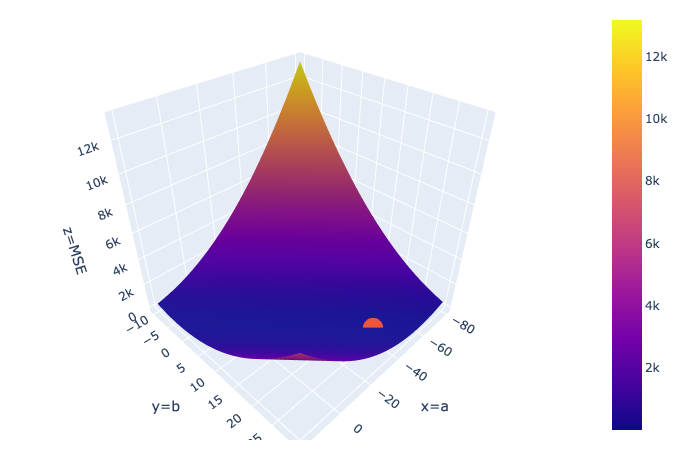

In [6]:
# just run this cell
import itertools
import plotly.graph_objects as go

def mse_linear(a, b, data_linear):
    data_x, data_y = data_linear.iloc[:,0], data_linear.iloc[:,1] # brittle
    return np.mean(np.array([(y - (a+b*x)) ** 2 for x, y in zip(data_x, data_y)]), axis=0)

a_values = np.linspace(-80, 20, 80)
b_values = np.linspace(-10,30, 80)
mse_values = [mse_linear(a, b, data_linear) \
              for a, b in itertools.product(a_values, b_values)]
mse_values = np.reshape(mse_values, (len(a_values), len(b_values)), order='F')

# optimal point
data_x, data_y = data_linear.iloc[:,0], data_linear.iloc[:,1] # brittle
b_hat = np.corrcoef(data_x, data_y)[0, 1] * np.std(data_y) / np.std(data_x)
a_hat = np.mean(data_y) - b_hat * np.mean(data_x)
fig_lin = go.Figure(data=[go.Surface(x=a_values, y=b_values, z=mse_values,name='z=loss')])
fig_lin.add_trace(go.Scatter3d(x=[a_hat], y=[b_hat], z=[mse_linear(a_hat, b_hat, data_linear)],
                           mode='markers', marker=dict(size=12),name='theta hat'))

fig_lin.update_layout(
    title=r'MSE for different values of $a, b$',
    autosize=False,
    scene = dict(
                    xaxis_title='x=a',
                    yaxis_title='y=b',
                    zaxis_title='z=MSE'),
                    width=500,
                    margin=dict(r=20, b=10, l=10, t=10))
fig_lin.show()

Plot both for lecture

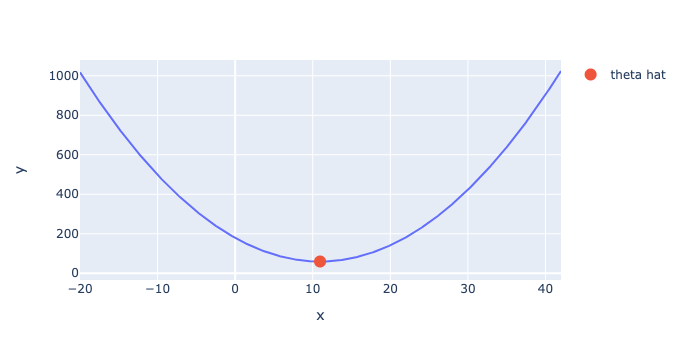

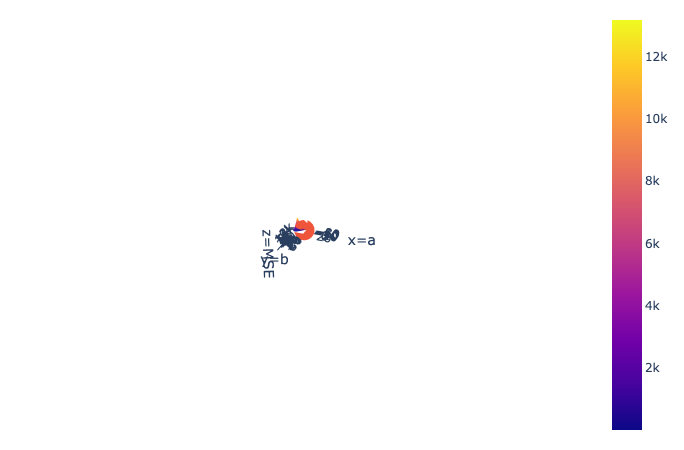

In [42]:
fig_const.show()
fig_lin.show()

## RMSE

In [8]:
print("Least Squares Constant Model RMSE:",
          np.sqrt(mse_constant(thetahat, data_constant)))
print("Least Squares Linear Model RMSE:  ",
          np.sqrt(mse_linear(a_hat, b_hat, data_linear)))

Least Squares Constant Model RMSE: 7.722422059764398
Least Squares Linear Model RMSE:   4.311332860288157


Interpret the RMSE (Root Mean Square Error):
* Constant model error is HIGHER than linear model error
* Linear model is BETTER than constant model (at least for this metric)

## Predictions

This plotting code is left for your reference. We'll mainly look at the figures in lecture.

In [9]:
yobs = data_linear["Age"]      # the true observations y
xs = data_linear["Length"]     # needed for linear predictions
n = len(yobs)                  # predictions

yhats_constant = [thetahat for i in range(n)]    # not used, but food for thought
yhats_linear = [a_hat + b_hat * x for x in xs]

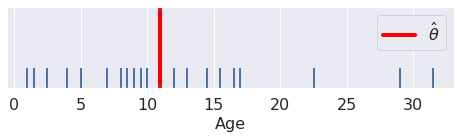

In [10]:
# in case we're in a weird style state
sns.set_theme()
adjust_fontsize(size=16)
%matplotlib inline

fig = plt.figure(figsize=(8, 1.5))
sns.rugplot(yobs, height=0.25, lw=2) ;
plt.axvline(thetahat, color='red', lw=4, label=r"$\hat{\theta}$");
plt.legend()
plt.yticks([])
#plt.savefig('dugong_rug.png', bbox_inches = 'tight');
plt.show()

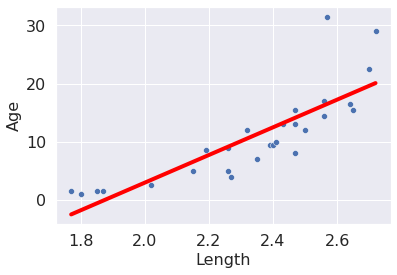

In [11]:
# in case we're in a weird style state
sns.set_theme()
adjust_fontsize(size=16)
%matplotlib inline

sns.scatterplot(x=xs, y=yobs)
plt.plot(xs, yhats_linear, color='red', lw=4)
#plt.savefig('dugong_line.png', bbox_inches = 'tight');
plt.show()

<br/><br/>

---

# Bubble Tea:  Two Constant Models, Fit to Different Losses

## Exploring MAE

In [12]:
boba = np.array([20, 21, 22, 29, 33])

Let's plot the $L_1$ loss for a **single** observation. We'll plot the $L_1$ loss for the first observation; since $y_1 = 20$, we'll be plotting

$$L_1(20, \theta) = |20 - \theta|$$

In [13]:
thetas = np.linspace(10, 30, 1000)
l1_loss_single_obvs = np.abs(boba[0] - thetas)

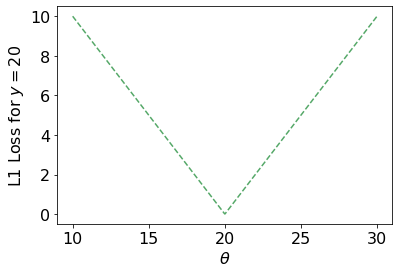

In [14]:
plt.style.use('default') # revert style to default mpl
adjust_fontsize(size=16)
%matplotlib inline

plt.plot(thetas, l1_loss_single_obvs,  'g--', );
plt.xlabel(r'$\theta$');
plt.ylabel(r'L1 Loss for $y = 20$');
#plt.savefig('l1_loss_single_obs.png', bbox_inches = 'tight');

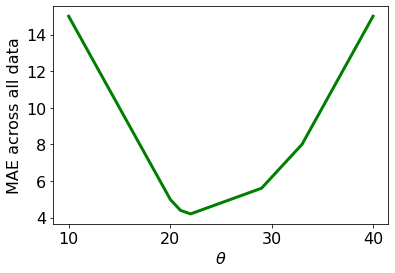

In [15]:
def mae_constant(theta, data):
    return np.mean(np.array([np.abs(y_obs - theta) for y_obs in data]), axis=0)

thetas = np.linspace(10, 40, 1000)
l1_loss_thetas = mae_constant(thetas, boba)
plt.plot(thetas, l1_loss_thetas, color = 'green', lw=3);
plt.xlabel(r'$\theta$');
plt.ylabel(r'MAE across all data');
#plt.savefig('l1_loss_average.png', bbox_inches = 'tight');

## Median Minimizes MAE for the Constant Model


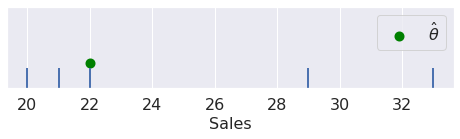

In [16]:
# in case we're in a weird style state
sns.set_theme()
adjust_fontsize(size=16)
%matplotlib inline

yobs = boba
thetahat = np.median(yobs)

fig = plt.figure(figsize=(8, 1.5))
sns.rugplot(yobs, height=0.25, lw=2) ;
plt.scatter([thetahat], [-.1], color='green', lw=4, label=r"$\hat{\theta}$");
plt.xlabel("Sales")
plt.legend()
plt.yticks([])
#plt.savefig('boba_rug.png', bbox_inches = 'tight');
plt.show()

## Two Constant Models, Fit to Different Losses

In [17]:
plt.style.use('default') # revert style to default mpl
adjust_fontsize(size=16)
%matplotlib inline


def plot_losses(data, title=None, theta_range=(10, 40)):
    thetas = np.linspace(theta_range[0], theta_range[1], 1000)
    l2_loss_thetas = mse_constant(thetas, data)
    thetahat_mse = np.mean(data)

    l1_loss_thetas = mae_constant(thetas, data)
    thetahat_mae = np.median(data)

    fig, axs = plt.subplots(1, nplots, figsize=(5*2+0.5, 3.5))
    axs[0].plot(thetas, l2_loss_thetas, lw=3);
    axs[0].scatter([thetahat_mse], [mse_constant(thetahat_mse, data)], s=100)
    axs[0].annotate(r"$\hat{\theta}$ = " + f"{thetahat_mse:.1f}",
                    xy=(thetahat_mse, np.average(axs[0].get_ylim())),
                    size=20, ha='center', va='top',
                    bbox=dict(boxstyle='round', fc='w'))
    axs[0].set_xlabel(r'$\theta$');
    axs[0].set_ylabel(r'MSE');

    axs[1].plot(thetas, l1_loss_thetas, color = 'green', lw=3);
    axs[1].scatter([thetahat_mae], [mae_constant(thetahat_mae, data)], color='green', s=100)
    axs[1].annotate(r"$\hat{\theta}$ = " + f"{thetahat_mae:.1f}",
                    xy=(thetahat_mae, np.average(axs[1].get_ylim())),
                    size=20, ha='center', va='top',
                    bbox=dict(boxstyle='round', fc='w'))
    axs[1].set_xlabel(r'$\theta$');
    axs[1].set_ylabel(r'MAE');
    if title:
        fig.suptitle(title)
    fig.tight_layout()
    return fig
    


<br/><br/><br/><br/>

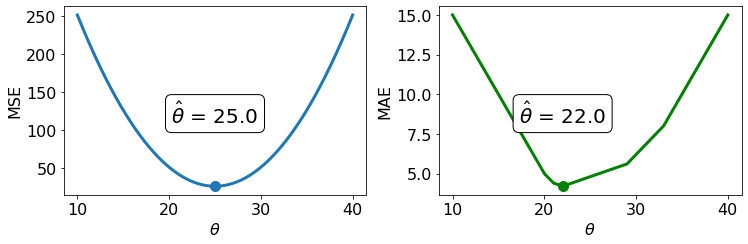

In [18]:
fig = plot_losses(boba)
plt.figure(fig)
#plt.savefig('loss_compare.png', bbox_inches = 'tight');
plt.show()

### More loss comparison: Outliers

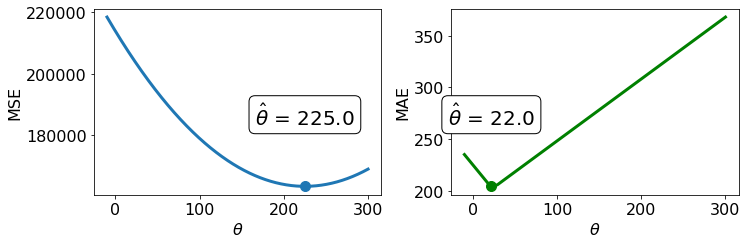

In [19]:
boba_outlier = np.array([20, 21, 22, 29, 1033])
fig = plot_losses(boba_outlier, theta_range=[-10, 300])
plt.figure(fig)
#plt.savefig('loss_outlier.png', bbox_inches = 'tight');
plt.show()

### Uniqueness under Different Loss Functions

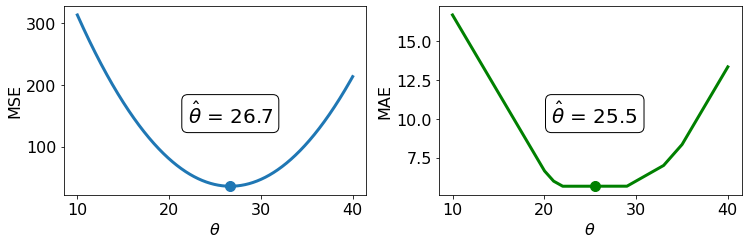

In [20]:
boba_even = np.array([20, 21, 22, 29, 33, 35])
fig = plot_losses(boba_even)
plt.figure(fig)
#plt.savefig('loss_unique.png', bbox_inches = 'tight');
plt.show()

### MAE loss curve for SLR?

Josh asked after lecture: The MSE (average L2) loss curve for Simple Linear Regression is smooth and parabolic in 3 dimensions. What does the MAE for SLR curve look like?

It's **beyond the scope of this course**, but for the curious, the below cell plots the mean absolute error (average L1 loss) on the boba dataset for a simple linear regression model . I don't plot the minimum because I don't know if there's a closed form solution (you could solve it numerically with techniques you learn in lab).

Since the boba dataset didn't have input, I've arbitrarily used "temperature of that day" as input. I made up the numbers (assume degrees Farenheit).

In [21]:
boba_df = pd.DataFrame({"sales": [20, 21, 22, 29, 33],
                        "temps": [40, 44, 55, 70, 85]},
                       columns=["temps", "sales"])
boba_df

,temps,sales
0,40,20
1,44,21
2,55,22
3,70,29
4,85,33


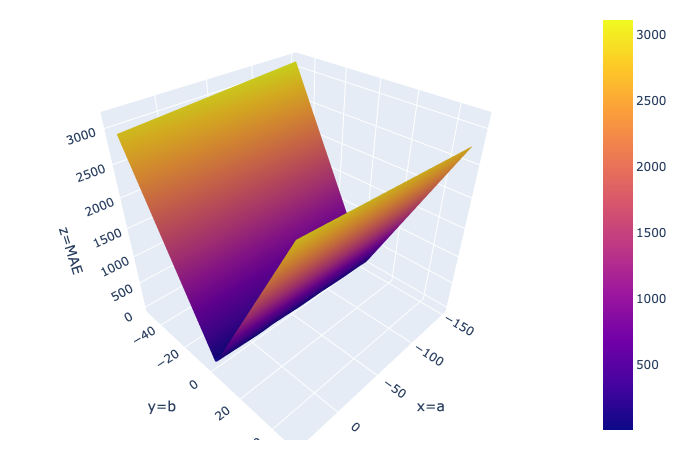

In [22]:
# just run this cell
import itertools
import plotly.graph_objects as go

data_linear = boba_df

def mAe_linear(a, b, data_linear):
    data_x, data_y = data_linear.iloc[:,0], data_linear.iloc[:,1] # brittle
    return np.mean(np.array([np.abs(y - (a+b*x)) for x, y in zip(data_x, data_y)]), axis=0)

a_values = np.linspace(-20, 20, 80)
b_values = np.linspace(-50, 50, 80)
mAe_values = [mAe_linear(a, b, data_linear) \
              for a, b in itertools.product(a_values, b_values)]
mAe_values = np.reshape(mAe_values, (len(a_values), len(b_values)), order='F')

# optimal point
fig_lin_mae = go.Figure(data=[go.Surface(x=a_values, y=b_values, z=mAe_values,name='z=loss')])

fig_lin_mae.update_layout(
    title=r'MAE for different values of $a, b$',
    autosize=False,
    scene = dict(
                    xaxis_title='x=a',
                    yaxis_title='y=b',
                    zaxis_title='z=MAE'),
                    width=500,
                    margin=dict(r=20, b=10, l=10, t=10))
fig_lin_mae.show()

<br/><br/>

---

# Revisiting SLR Evaluation

In [21]:
# helper functions
def standard_units(x):
    return (x - np.mean(x)) / np.std(x)

def correlation(x, y):
    return np.mean(standard_units(x) * standard_units(y))

def slope(x, y):
    return correlation(x, y) * np.std(y) / np.std(x)

def intercept(x, y):
    return np.mean(y) - slope(x, y)*np.mean(x)

def fit_least_squares(x, y):
    ahat = intercept(x, y)
    bhat = slope(x, y)
    return ahat, bhat

def predict(x, ahat, bhat):
    return ahat + bhat*x

def compute_mse(y, yhat):
    return np.mean((y - yhat)**2)

In [22]:
plt.style.use('default') # revert style to default mpl
NO_VIZ, RESID, RESID_SCATTER = range(3)
def least_squares_evaluation(x, y, visualize=NO_VIZ):
    # statistics
    print(f"x_mean : {np.mean(x):.2f}, y_mean : {np.mean(y):.2f}")
    print(f"x_stdev: {np.std(x):.2f}, y_stdev: {np.std(y):.2f}")
    print(f"r = Correlation(x, y): {correlation(x, y):.3f}")
    
    # performance metrics
    ahat, bhat = fit_least_squares(x, y)
    yhat = predict(x, ahat, bhat)
    print(f"ahat: {ahat:.2f}, bhat: {bhat:.2f}")
    print(f"RMSE: {np.sqrt(compute_mse(y, yhat)):.3f}")

    # visualization
    fig, ax_resid = None, None
    if visualize == RESID_SCATTER:
        fig, axs = plt.subplots(1,2,figsize=(8, 3))
        axs[0].scatter(x, y)
        axs[0].plot(x, yhat)
        axs[0].set_title("LS fit")
        ax_resid = axs[1]
    elif visualize == RESID:
        fig = plt.figure(figsize=(4, 3))
        ax_resid = plt.gca()
    
    if ax_resid is not None:
        ax_resid.scatter(x, y - yhat, color = 'red')
        ax_resid.plot([4, 14], [0, 0], color = 'black')
        ax_resid.set_title("Residuals")
    
    return fig

In [23]:
# Load in four different datasets: I, II, III, IV
anscombe = sns.load_dataset('anscombe')
anscombe['dataset'].value_counts()

I      11
II     11
III    11
IV     11
Name: dataset, dtype: int64

Wow, looks like all four datasets have the same:
* statistics of $x$ and $y$
* correlation $r$
* regression line parameters $\hat{a}, \hat{b}$
* RMSE (average squared loss)

### Plot Residuals

>>> Dataset I:
x_mean : 9.00, y_mean : 7.50
x_stdev: 3.16, y_stdev: 1.94
r = Correlation(x, y): 0.816
ahat: 3.00, bhat: 0.50
RMSE: 1.119


>>> Dataset II:
x_mean : 9.00, y_mean : 7.50
x_stdev: 3.16, y_stdev: 1.94
r = Correlation(x, y): 0.816
ahat: 3.00, bhat: 0.50
RMSE: 1.119


>>> Dataset III:
x_mean : 9.00, y_mean : 7.50
x_stdev: 3.16, y_stdev: 1.94
r = Correlation(x, y): 0.816
ahat: 3.00, bhat: 0.50
RMSE: 1.118


>>> Dataset IV:
x_mean : 9.00, y_mean : 7.50
x_stdev: 3.16, y_stdev: 1.94
r = Correlation(x, y): 0.817
ahat: 3.00, bhat: 0.50
RMSE: 1.118




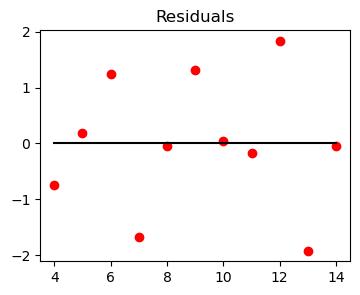

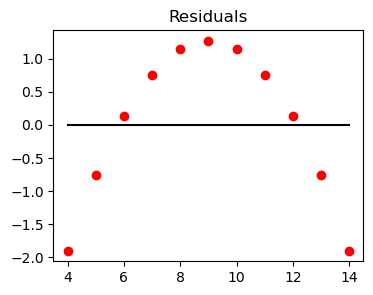

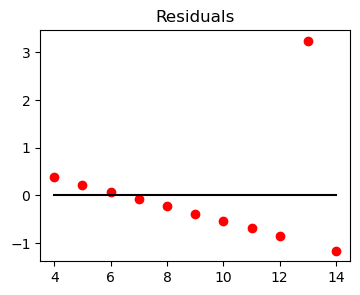

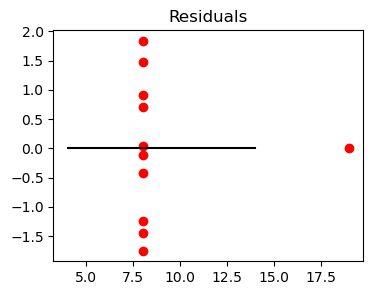

In [24]:
for dataset in ['I', 'II', 'III', 'IV']:
    print(f">>> Dataset {dataset}:")
    ans = anscombe[anscombe['dataset'] == dataset]
    fig = least_squares_evaluation(ans['x'], ans['y'], visualize=RESID)
    #plt.savefig(f"anscombe1_{dataset}.png")
    #plt.show(fig)
    print()
    print()

# Dugongs Part 2

## Residual Plot

In [38]:
dugongs = pd.read_csv("data/dugongs.csv")
dugongs.head()

,Length,Age
0,1.77,1.5
1,1.80,1.0
2,1.85,1.5
3,1.87,1.5
4,2.02,2.5


In [39]:
yobs = dugongs["Age"]      # the true observations y
xs = dugongs["Length"]     # needed for linear predictions

b_hat = np.corrcoef(xs, yobs)[0, 1] * np.std(yobs) / np.std(xs)
a_hat = np.mean(yobs) - b_hat * np.mean(xs)
yhats_linear = a_hat + b_hat * xs

In [40]:
np.corrcoef(xs, yobs)[0, 1]

0.8296474554905716

The correlation coefficient is pretty high...but there's an issue.

Let's first plot the Dugong linear fit again. It doesn't look so bad if we see it here.

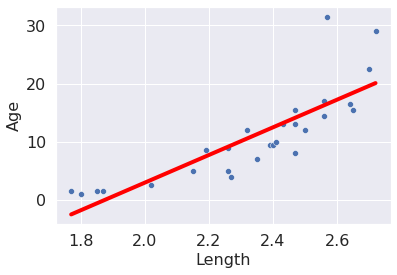

In [28]:
# in case we're in a weird style state
sns.set_theme()
adjust_fontsize(size=16)
%matplotlib inline

sns.scatterplot(x=xs, y=yobs)
plt.plot(xs, yhats_linear, color='red', lw=4)
#plt.savefig('dugong_line.png', bbox_inches = 'tight');
plt.show()

Let's further inspect by plotting residuals.

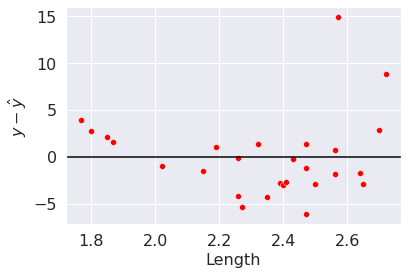

In [29]:
residuals = yobs - yhats_linear

sns.scatterplot(x=xs, y=residuals, color='red', lw=4)
plt.axhline(0, color='black')
plt.ylabel(r"$y - \hat{y}$")
#plt.savefig('dugong_residuals.png', bbox_inches = 'tight');
plt.show()

### Log transformation of y

We could fit a line to the linear model that relates $ z = \log(y)$ to $x$:

$$ \hat{z} = a = b x$$

In [30]:
dugongs["Log(Age)"] = np.log(dugongs["Age"])
zobs = dugongs["Log(Age)"]      # the LOG of true observations y
xs = dugongs["Length"]     # needed for linear predictions

zb_hat = np.corrcoef(xs, zobs)[0, 1] * np.std(zobs) / np.std(xs)
za_hat = np.mean(zobs) - zb_hat * np.mean(xs)
zhats_linear = za_hat + zb_hat * xs

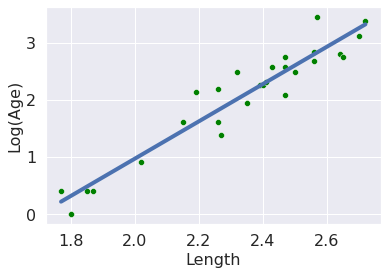

In [31]:
sns.scatterplot(x=xs, y=zobs, color='green')
plt.plot(xs, zhats_linear, lw=4)
#plt.savefig('dugong_zline.png', bbox_inches = 'tight');
plt.show()

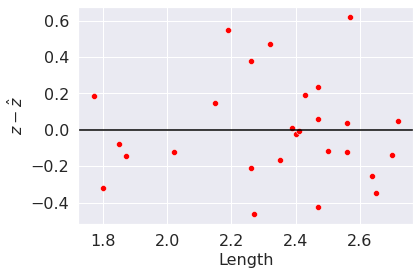

In [32]:
zresiduals = zobs - zhats_linear

sns.scatterplot(x=xs, y=zresiduals, color='red', lw=4)
plt.axhline(0, color='black')
plt.ylabel(r"$z - \hat{z}$")
#plt.savefig('dugong_zresiduals.png', bbox_inches = 'tight');
plt.show()

### Map back to the original coordinates

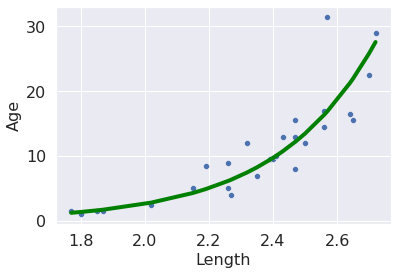

In [33]:
ypred = np.exp(zhats_linear)
sns.scatterplot(x=xs, y=yobs)
plt.plot(xs, ypred, color='green', lw=4)
#plt.savefig('dugong_curve.png', bbox_inches = 'tight');
plt.show()